In [2]:
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import rcParams
import psutil
import random
import json


In [3]:
behav_news = pd.read_csv ("MIND/mind_version1/MIND_Demo_Version1/train/behaviour_News_train_1000Users.csv") #, names= ["user", "item", "rating"])
# behav_news = pd.read_csv ("/Users/mslokom/Documents/RecSys_News/MIND/MIND_Demo_Version1/Train/behaviors.tsv", sep= "\t") #, names= ["user", "item", "rating"])
behav_news_cat = behav_news [["userId", "click_history", "category"]]#, "noclicks", "click", "category"]]
behav_news_cat#.head (5)


,userId,click_history,category
0,U82271,N3130,lifestyle
1,U82271,N11621,sports
2,U82271,N12917,news
3,U82271,N4574,tv
4,U82271,N12140,sports
...,...,...,...
39379,U47006,N24461,health
39380,U47006,N14065,lifestyle
39381,U47006,N425,lifestyle
39382,U47006,N5697,sports


In [4]:

selected_data = behav_news_cat.copy()

In [5]:
## Indexize users
unique_userIds = selected_data['userId'].unique()
unique_itemIds = selected_data['click_history'].unique()

# Allocate a unique index for each user, but let the zeroth index be a UNK index:
ind2user = {idx +1: userid for idx, userid in enumerate(unique_userIds)}
user2ind = {userid : idx for idx, userid in ind2user.items()}
print(f"We have {len(user2ind)} unique users in the dataset")
nb_users= len(user2ind)

ind2item = {idx +1: itemid for idx, itemid in enumerate(unique_itemIds)}
item2ind = {itemid : idx for idx, itemid in ind2item.items()}
print(f"We have {len(item2ind)} unique items in the dataset")
nb_items= len(item2ind)

# Create a new column with userIdx:
selected_data['userIdx'] = selected_data['userId'].map(lambda x: user2ind.get(x,0))
selected_data['itemIdx'] = selected_data['click_history'].map(lambda x: item2ind.get(x,0))

# behav_news_cat.head(5)

We have 1000 unique users in the dataset
We have 9369 unique items in the dataset


In [6]:
# grouped_df= df_filtered.copy()
# Number of unique user_ids and book_ids
num_unique_users = selected_data['userId'].nunique() # userIdx
# num_unique_books = behav_news_cat['itemId'].nunique() # ItemID
num_unique_news_hist = selected_data['click_history'].nunique() # click_history_idx

# Total possible interactions (assuming all combinations exist)
total_possible_interactions = num_unique_users * num_unique_news_hist

# Actual number of interactions (non-zero ratings)
num_interactions = selected_data.shape[0]

# Sparsity calculation
sparsity = 1.0 - (num_interactions / total_possible_interactions)

# Print the results
print(f"Number of unique user_ids: {num_unique_users}")
print(f"Number of unique news_ids: {num_unique_news_hist}")
print(f"Number of unique news_ids: {num_unique_news_hist}")

print(f"Sparsity of the data: {sparsity:.4f}")

Number of unique user_ids: 1000
Number of unique news_ids: 9368
Number of unique news_ids: 9368
Sparsity of the data: 0.9958


In [7]:

selected_data['userId'].value_counts ()

U79449    336
U54826    304
U44210    259
U72280    235
U14271    214
         ... 
U38248      1
U40535      1
U88124      1
U59111      1
U13959      1
Name: userId, Length: 1000, dtype: int64

In [10]:
# Merge the DataFrames based on the 'userIdx' and 'click_history_idx' column
train_MIND_categories = selected_data.copy () # trains.merge(behav_news_cat, on=['userId', 'click_history'], how='inner')
train_MIND_categories

,userId,click_history,category,userIdx,itemIdx
0,U82271,N3130,lifestyle,1,1
1,U82271,N11621,sports,1,2
2,U82271,N12917,news,1,3
3,U82271,N4574,tv,1,4
4,U82271,N12140,sports,1,5
...,...,...,...,...,...
39379,U47006,N24461,health,1000,12
39380,U47006,N14065,lifestyle,1000,133
39381,U47006,N425,lifestyle,1000,60
39382,U47006,N5697,sports,1000,3433


In [11]:
train_MIND_categories.category.value_counts()

news             11866
sports            5683
lifestyle         4141
finance           3046
tv                3006
foodanddrink      2026
health            1756
movies            1510
autos             1482
entertainment     1310
travel            1266
music             1108
video              686
weather            475
Name: category, dtype: int64

In [13]:
train_MIND_categories['is_duplicate'] = train_MIND_categories.duplicated(subset=['userId', 'click_history'], keep=False)

# Display the DataFrame with the new 'is_duplicate' column
user_U82271 = train_MIND_categories[train_MIND_categories['userId'] == 'U82271']
user_U82271

,userId,click_history,category,userIdx,itemIdx,is_duplicate
0,U82271,N3130,lifestyle,1,1,False
1,U82271,N11621,sports,1,2,False
2,U82271,N12917,news,1,3,False
3,U82271,N4574,tv,1,4,False
4,U82271,N12140,sports,1,5,False
5,U82271,N9748,health,1,6,False


In [15]:
# Step 1: Create a dictionary of item IDs and their corresponding genres
# item_genres = {}
# for _, row in train_MIND_categories.iterrows():
#     item_id = row['itemIdx']
#     genres = row['category']
#     if item_id not in item_genres:
#         item_genres[item_id] = set()  # Using a set to ensure uniqueness
#     item_genres[item_id].add(genres)
# Step 1: Create a dictionary of item IDs and their corresponding genres
item_genres = {}
for _, row in train_MIND_categories.iterrows():
    item_id = row['itemIdx']
    genres = row['category']

    # Skip items with NaN categories
    if not pd.isna(genres):
        if item_id not in item_genres:
            item_genres[item_id] = set()  # Using a set to ensure uniqueness
        item_genres[item_id].add(genres)
# print (item_genres)
# Step 2: Create a list of unique genre labels
unique_genres = list(set(genre for genres in item_genres.values() for genre in genres))
# Step 3: Map the genres of each item to unique labels and store in a dictionary
unique_item_features = {}
for item_id, genres in item_genres.items():
    feature_vector = [1 if genre in genres else 0 for genre in unique_genres]
    unique_item_features[item_id] = ':'.join([str(unique_genres[i]) for i, value in enumerate(feature_vector) if value == 1])

# # Step 4: Convert the dictionary into a list of unique item features
# unique_item_features_list = [unique_item_features[item_id] for item_id in unique_item_features.keys()]
# Step 4: Remove NaN values from the list of unique item features
# unique_item_features_list = [item_feature for item_feature in unique_item_features.values() if isinstance(item_feature, str)]
unique_item_features_list = [item_feature for item_feature in unique_item_features.values() if isinstance(item_feature, str) and not pd.isna(item_feature)]
# Print the unique_item_features_list
print(len(unique_item_features_list))
item_features = np.array(unique_item_features_list)
# for item_feature in item_features:
item_features

9368


array(['lifestyle', 'sports', 'news', ..., 'health', 'finance', 'sports'],
      dtype='<U13')

In [45]:
# import GoodBookData as GBD
from PerBlur import MinData
# X, reverse_user_id_mapping, reverse_item_id_mapping = MinData.load_user_item_matrix_Mind_TrainingSet1()
X = MinData.load_user_item_matrix_Mind_TrainingSet()
user_item_matrix =X
X#= X[:1000, :]
X_test = MinData.load_user_item_matrix_Mind_TestSet()
# X_test

user-item matrix


In [17]:
item_user_matrix = X.T
item_user_matrix.shape

(9368, 1000)

In [20]:
# Set a seed for reproducibility
np.random.seed(42)

# Sample or generate new item_ids based on the unique_item_ids
num_samples = 9368 # 15558  # Adjust the number of samples as needed
sampled_item_ids = np.random.choice(train_MIND_categories.itemIdx.unique(), size=num_samples, replace=True)
# Create a new DataFrame with the sampled_item_ids
new_item_df = pd.DataFrame({'item_id': sampled_item_ids})

# Iterate through the rows in the data frame
for index, row in enumerate(item_features):
    categories = row.split(':')
    for category in categories:
        # print (category)
        if category not in new_item_df.columns:
            new_item_df[category] = 0
        new_item_df.loc[index, category] = 1

# Initialize an empty dictionary to store indicative users for each category
users_by_category = {}

# Iterate through each unique category label
unique_categories = new_item_df.loc[:, new_item_df.columns != "item_id"]
unique_categories = unique_categories.columns
print (unique_categories)
# Iterate through each unique category label
for category in unique_categories:
    # Initialize a logistic regression model for binary classification
    logistic_model = LogisticRegression()
    
    # Create a binary label vector for the current category
    category_labels = new_item_df[category]
    
    # Fit the logistic regression model for the current category
    # Use the new user IDs directly for training the model
    logistic_model.fit(item_user_matrix, category_labels)
    
    # Get the coefficients for each user
    user_coefficients = logistic_model.coef_[0]
    
    # Find users with positive coefficients (indicative of the current category)
    category_users = np.where(user_coefficients > 0)[0]
    
    # Store the users in the dictionary under each category using the new user IDs directly
    users_by_category[category] = list(category_users)

# Now, users_by_category is a dictionary where keys are category names, and values are lists of new user IDs indicative of each category.
# You can access and print the data for each category as follows:

for category, user_ids in users_by_category.items():
    print(f"Category: {category}")
    print(f"User IDs: {user_ids}")

Index(['lifestyle', 'sports', 'news', 'tv', 'health', 'foodanddrink',
       'finance', 'autos', 'music', 'entertainment', 'movies', 'travel',
       'video', 'weather'],
      dtype='object')
Category: lifestyle
User IDs: [0, 5, 6, 7, 9, 10, 11, 13, 15, 16, 17, 19, 20, 26, 27, 28, 31, 37, 39, 42, 43, 47, 49, 50, 54, 59, 60, 61, 62, 76, 78, 80, 85, 87, 88, 94, 95, 96, 99, 101, 104, 106, 108, 110, 112, 113, 117, 118, 120, 121, 123, 125, 126, 130, 135, 136, 137, 140, 143, 147, 150, 155, 157, 158, 160, 161, 162, 164, 167, 168, 170, 171, 172, 173, 175, 177, 179, 182, 183, 187, 191, 195, 196, 197, 201, 202, 203, 209, 211, 213, 214, 217, 221, 225, 227, 228, 229, 230, 231, 232, 233, 236, 237, 238, 239, 240, 246, 247, 256, 257, 258, 259, 260, 262, 263, 264, 272, 273, 283, 285, 288, 294, 297, 301, 306, 307, 308, 309, 313, 315, 316, 317, 318, 323, 324, 328, 329, 330, 332, 333, 336, 337, 338, 339, 340, 343, 344, 351, 353, 355, 356, 358, 365, 368, 369, 370, 376, 377, 379, 381, 382, 389, 394, 395, 

# -1-: Get a List of Items Belonging to Each Category

Given your data frame with item IDs and categories, you can split the categories and create a dictionary where each category maps to a list of item IDs. Here's an example:

In [21]:
threshold = 50

# Sample data frame with item IDs and categories
item_df = train_MIND_categories[["itemIdx", "category"]] # click_history

# Initialize a dictionary to store items by category
items_by_category = {}

# Iterate through the rows in the data frame
for index, row in item_df.iterrows():
    item_id = row['itemIdx'] # click_history
    category = row['category']
    
    # Check if the category is already in the dictionary
    if category in items_by_category:
        if len(items_by_category[category]) < threshold:
            items_by_category[category].append(item_id)
    else:
        items_by_category[category] = [item_id]

# Now, items_by_category is a dictionary where keys are categories, and values are lists of item IDs belonging to each category
items_by_category


{'lifestyle': [1,
  52,
  60,
  65,
  80,
  83,
  90,
  94,
  105,
  109,
  111,
  116,
  117,
  121,
  133,
  144,
  152,
  154,
  161,
  165,
  188,
  200,
  202,
  205,
  133,
  209,
  116,
  225,
  231,
  233,
  60,
  250,
  254,
  257,
  270,
  271,
  275,
  277,
  296,
  304,
  310,
  320,
  336,
  358,
  364,
  372,
  374,
  380,
  406,
  407],
 'sports': [2,
  5,
  18,
  19,
  2,
  20,
  23,
  28,
  29,
  37,
  38,
  41,
  44,
  45,
  47,
  48,
  51,
  62,
  63,
  69,
  70,
  72,
  74,
  75,
  127,
  131,
  132,
  135,
  171,
  176,
  185,
  194,
  199,
  212,
  235,
  287,
  290,
  291,
  295,
  299,
  302,
  306,
  307,
  312,
  313,
  315,
  318,
  321,
  322,
  323],
 'news': [3,
  9,
  11,
  16,
  61,
  64,
  67,
  79,
  81,
  85,
  87,
  89,
  92,
  95,
  97,
  98,
  100,
  108,
  115,
  119,
  123,
  128,
  130,
  136,
  137,
  138,
  141,
  142,
  143,
  145,
  146,
  9,
  150,
  151,
  166,
  169,
  177,
  180,
  182,
  186,
  189,
  190,
  195,
  196,
  206,
  207,
  

# -2-: Create a Dictionary with User Preferences
Given a dictionary with user IDs and their preferred items, you can directly create this dictionary in Python. 

*This is to be created using UserKNN + confidence scores: check notebook 00-MIND-eda.ipynb*

In [24]:
# Load the original user and item mappings
# X, reverse_user_id_mapping, reverse_item_id_mapping = MinData.load_user_item_matrix_Mind_TrainingSet()
# X= X[:1000, :]

# Load the JSON file containing the simplified user-item interactions
with open('MIND/mind_version1/MIND_demo/With_Fancy_KNN/MIND_NN_TrainingSet_AllUsers_Neighbors_Weight_K_30_item_choice_TopAllIndicativeItems_1000Users_V1.json') as json_file:
    simplified_data = json.load(json_file)
"""
# Create dictionaries to store mappings between simplified and original user and item IDs
user_id_mapping = {}  # Map from simplified user ID to original user ID
item_id_mapping = {}  # Map from simplified user ID to list of original item IDs

# Iterate through the simplified data and create mappings
for simplified_user_id, item_list in simplified_data.items():
    # Map user ID
    original_user_id = reverse_user_id_mapping[int(simplified_user_id)]
    user_id_mapping[simplified_user_id] = original_user_id

    # Map item IDs
    original_item_ids = [reverse_item_id_mapping[int(simplified_item_id)] for simplified_item_id in item_list]
    item_id_mapping[simplified_user_id] = original_item_ids

# Create a new dictionary with original user and item IDs
new_data_with_original_ids = {}
for simplified_user_id, original_user_id in user_id_mapping.items():
    original_item_ids = item_id_mapping[simplified_user_id]
    new_data_with_original_ids[str(original_user_id)] = [str(item_id) for item_id in original_item_ids]

# Save the new JSON file with original user and item IDs
output_file_path = '/Users/mslokom/Documents/RecSys_News/MIND/mind_version1/MIND_demo/With_Fancy_KNN/MIND_NN_TrainingSet_AllUsers_Neighbors_Weight_K_30_item_choice_TopAllIndicativeItems_1000Users_OriginalIDs_V2.json'
with open(output_file_path, 'w') as json_output_file:
    json.dump(new_data_with_original_ids, json_output_file, indent=4)

print(f"New JSON file saved to: {output_file_path}")
"""

'\n# Create dictionaries to store mappings between simplified and original user and item IDs\nuser_id_mapping = {}  # Map from simplified user ID to original user ID\nitem_id_mapping = {}  # Map from simplified user ID to list of original item IDs\n\n# Iterate through the simplified data and create mappings\nfor simplified_user_id, item_list in simplified_data.items():\n    # Map user ID\n    original_user_id = reverse_user_id_mapping[int(simplified_user_id)]\n    user_id_mapping[simplified_user_id] = original_user_id\n\n    # Map item IDs\n    original_item_ids = [reverse_item_id_mapping[int(simplified_item_id)] for simplified_item_id in item_list]\n    item_id_mapping[simplified_user_id] = original_item_ids\n\n# Create a new dictionary with original user and item IDs\nnew_data_with_original_ids = {}\nfor simplified_user_id, original_user_id in user_id_mapping.items():\n    original_item_ids = item_id_mapping[simplified_user_id]\n    new_data_with_original_ids[str(original_user_id)] =

In [26]:
item_choice = simplified_data# new_data_with_original_ids
item_choice

{'0': [7775,
  10429,
  10430,
  10431,
  10432,
  10433,
  10434,
  10435,
  10436,
  10437,
  10438,
  10439,
  10440,
  10441,
  10442,
  10443,
  10444,
  10445,
  10446,
  10447,
  10448,
  10449,
  10450,
  10451,
  10452,
  10453,
  10428,
  10427,
  10426,
  10425,
  10399,
  10400,
  10401,
  10402,
  10403,
  10404,
  10405,
  10406,
  10407,
  10408,
  10409,
  10410,
  10454,
  10411,
  10413,
  10414,
  10415,
  10416,
  10417,
  10418,
  10419,
  10420,
  10421,
  10422,
  10423,
  10424,
  10412,
  10455,
  10456,
  10457,
  10488,
  10489,
  10490,
  10491,
  10492,
  10493,
  10494,
  10495,
  10496,
  10497,
  10498,
  10499,
  10487,
  10500,
  10502,
  10503,
  10504,
  10505,
  10506,
  10507,
  10508,
  10509,
  10510,
  10511,
  10512,
  10513,
  10501,
  10398,
  10486,
  10484,
  10458,
  10459,
  10460,
  10461,
  10462,
  10463,
  10464,
  10465,
  10466,
  10467,
  10468,
  10469,
  10485,
  10470,
  10472,
  10473,
  10474,
  10475,
  10476,
  10477,
  1047

## -3-: Find categories that are the most similar to each other based on user preferences

## Create a personalized list of indicative items per user based on their preferences and the available categories. 

Now that we have user_preferences, items_by_category, and data_by_category (from which we can get users_by_category). We want to create the final *personalized list of indicative items per user* using the three inputs user_preferences, items_by_category and users_by_category. 

The algorithm is as follows: 

if user is in users_by_category (and maybe other categories in users_by_category) then: 

    1- choose randomly a category that a user does not belong to

    2- intersect items in the chosen category from items_by_category with items in user_preferences. 
    
    3- create Personalized_list_user (so this will be list for every user with item ids)

In [27]:
# Define the final personalized list of indicative items per user
personalized_lists = {}

# Iterate through each user
for user_id, preferences in item_choice.items():
    # Initialize the personalized list for the current user
    personalized_list_user = []

    # Find the categories the user belongs to
    user_categories = users_by_category.get(user_id, [])  # Use an empty list if the user has no categories
    # Choose randomly a category that the user does not belong to
    non_member_categories = [category for category in items_by_category.keys() if category not in user_categories]
    print (non_member_categories)
    if non_member_categories:
        chosen_category = random.choice(non_member_categories)
        print (chosen_category)
        # Intersect items in the chosen category with items in user preferences
        category_items = items_by_category.get(chosen_category, [])  # Use an empty list if the category has no items
        personalized_list_user = list(set(category_items).intersection(preferences))

    # Add the personalized list to the final dictionary
    personalized_lists[user_id] = personalized_list_user
    # print (personalized_lists)
# Print the personalized lists for each user
for user_id, personalized_list in personalized_lists.items():
    print(f'User {user_id}: {personalized_list}')


['lifestyle', 'sports', 'news', 'tv', 'health', 'foodanddrink', 'finance', 'autos', 'music', 'entertainment', 'movies', 'travel', 'video', 'weather', nan]
health
['lifestyle', 'sports', 'news', 'tv', 'health', 'foodanddrink', 'finance', 'autos', 'music', 'entertainment', 'movies', 'travel', 'video', 'weather', nan]
video
['lifestyle', 'sports', 'news', 'tv', 'health', 'foodanddrink', 'finance', 'autos', 'music', 'entertainment', 'movies', 'travel', 'video', 'weather', nan]
music
['lifestyle', 'sports', 'news', 'tv', 'health', 'foodanddrink', 'finance', 'autos', 'music', 'entertainment', 'movies', 'travel', 'video', 'weather', nan]
weather
['lifestyle', 'sports', 'news', 'tv', 'health', 'foodanddrink', 'finance', 'autos', 'music', 'entertainment', 'movies', 'travel', 'video', 'weather', nan]
travel
['lifestyle', 'sports', 'news', 'tv', 'health', 'foodanddrink', 'finance', 'autos', 'music', 'entertainment', 'movies', 'travel', 'video', 'weather', nan]
autos
['lifestyle', 'sports', 'news'

# Obfuscation
Let's start having the fun now. 
So we want to go through all users and for each user we obfuscate the profile. 
This is called obfuscation by adding fake rating score = 1
for user in total list of users do:

    count: this is a variable keeping count of the number of added fake rating score. It is equal to initial count (number of iteraction ina user profile) * p (where p is percentage that we initialize about the percentage of fake items we want to add in a user profile). Say p = 1%. so we will 1% of the total profile size into the user profile. Then count = initial count * p

    variable: added = 0
    
    while added < count do:

        i= picks the item in the first position in personalized_list for the given user

        If the cell in the item-user matrix for given user in item i then:

            replace the cell value with 1

            increment added += 1

    keep track on the total added += added

## Greedy selection for Obfuscation

## Random Selection for obfuscation

### Optimized Code

This function obfuscates a user-item interaction matrix by adding a small percentage of interactions to the matrix. The interactions to be added can be selected either randomly or based on a personalized list of items for each user, depending on the chosen mode (greedy or random). The function ensures that added interactions are not already present in the user's interaction history and do not appear in a given test set.



In [608]:
def obfuscate_user_item_matrix(user_item_matrix, X_test, personalized_lists=None, p=0.01, mode='greedy'):

    """
    This function obfuscates a user-item interaction matrix by adding a small percentage of interactions to the matrix. The interactions to be added can be selected either randomly or based on a personalized list of items for each user, depending on the chosen mode (greedy or random). The function ensures that added interactions are not already present in the user's interaction history and do not appear in a given test set.

    Parameters
    - user_item_matrix (np.ndarray): The original user-item interaction matrix.
    - X_test (np.ndarray): The test set matrix used to ensure interactions are not added if they appear in this set.
    - personalized_lists (dict, optional): A dictionary where keys are user IDs and values are lists of item IDs. Used in the greedy mode to select items for obfuscation based on personalized recommendations.
    - p (float, optional, default=0.01): The percentage of existing interactions to add as obfuscated interactions.
    - mode (str, optional, default='greedy'): The mode of obfuscation. Can be 'greedy' to use the personalized lists for adding interactions or 'random' to add interactions randomly.
    Returns
    np.ndarray: The obfuscated user-item interaction matrix.

    
    """


    num_users, num_items = user_item_matrix.shape

    obfuscated_matrix = np.copy(user_item_matrix)
    total_added = 0

    for user_id in range(num_users):
        count = int(np.sum(obfuscated_matrix[user_id, :]) * p)
        added = 0

        # Track items that already exist in the user's interaction history
        existing_items = set(np.where(obfuscated_matrix[user_id, :] == 1)[0])

        if mode == 'greedy' and personalized_lists and user_id in personalized_lists:
            personalized_list = personalized_lists[user_id]
            for item_id in personalized_list:
                if added >= count or total_added >= 1000:
                    break

                if item_id not in existing_items and X_test[user_id, item_id] == 0:
                    obfuscated_matrix[user_id, item_id] = 1
                    existing_items.add(item_id)
                    added += 1
        elif mode == 'random':
            while added < count and total_added < 1000:
                item_id = np.random.randint(0, num_items)

                if item_id not in existing_items and X_test[user_id, item_id] == 0:
                    obfuscated_matrix[user_id, item_id] = 1
                    existing_items.add(item_id)
                    added += 1

        total_added += added

    return obfuscated_matrix

X_test = X_test.copy ()
p_obfuscation = 0.05
mode='random'
Adding_user_item_matrix = obfuscate_user_item_matrix(X, X_test, personalized_lists=personalized_lists, p=p_obfuscation, mode=mode)

# Convert the obfuscated matrix to a list of tuples containing (user_id, item_id)
rows = []
for user_id, user_ratings in enumerate(Adding_user_item_matrix):
    for item_id, rating in enumerate(user_ratings):
        if rating > 0:
            rows.append((user_id + 1, item_id + 1))

# Create a DataFrame from the list of tuples
df = pd.DataFrame(rows, columns=['user_id', 'item_id'])

# Map to original IDs in train_MIND_categories
train_MIND_categories = selected_data.copy()
user2ind = {user_id: idx for idx, user_id in enumerate(train_MIND_categories['userId'].unique(), start=1)}
item2ind = {item_id: idx for idx, item_id in enumerate(train_MIND_categories['click_history'].unique(), start=1)}

df['userId'] = df['user_id'].map(lambda x: train_MIND_categories.loc[train_MIND_categories['userIdx'] == x, 'userId'].iloc[0] if x in train_MIND_categories['userIdx'].values else 0)
df['click_history'] = df['item_id'].map(lambda x: train_MIND_categories.loc[train_MIND_categories['itemIdx'] == x, 'click_history'].iloc[0] if x in train_MIND_categories['itemIdx'].values else 0)

# Save the DataFrame to a CSV file with the mode in the filename
csv_filename = f"MIND/mind_version1/MIND_demo/Random/Adding_user_item_matrix_{p_obfuscation}_{mode}.csv"
df.to_csv(csv_filename, index=False)

df


,user_id,item_id,userId,click_history
0,1,1,U82271,N3130
1,1,2,U82271,N11621
2,1,3,U82271,N12917
3,1,4,U82271,N4574
4,1,5,U82271,N12140
...,...,...,...,...
40378,1000,60,U47006,N425
40379,1000,133,U47006,N14065
40380,1000,343,U47006,N17008
40381,1000,586,U47006,N20753


In [609]:
print (len (train_MIND_categories.click_history.unique()))
print (len (df.item_id.unique()))

9369
9368


In [610]:
duplicatet = df[df.duplicated(subset=['userId', 'click_history'], keep=False)]
df['is_duplicate'] = df.duplicated(subset=['userId', 'click_history'], keep=False)
duplicatet
# Display the DataFrame with the new 'is_duplicate' column
user_U68381 = df[df['userId'] == 'U68381']
# user_U68381

In [611]:
df.click_history.value_counts()

N18426    162
N14065    139
N4617     127
N25457    122
N26676    112
         ... 
N21517      1
N4013       1
N25131      1
N5292       1
N8535       1
Name: click_history, Length: 9367, dtype: int64

# Removal strategy

### Version 1 in the removal

## Optimized code

In [614]:
def remove_ratings_with_original_ids(user_item_matrix, personalized_lists, X_test, threshold=20, removal_mode="strategic", X=20, safety_count=50): 
    """
    This function, remove_ratings_with_original_ids, obfuscates a user-item interaction matrix by either strategically or randomly removing interactions based on specified parameters. The obfuscated matrix and a DataFrame listing the remaining interactions are returned and saved to a CSV file.

    Parameters:
        - user_item_matrix (np.ndarray): The original user-item interaction matrix.
        - personalized_lists (dict): A dictionary where keys are user indices and values are lists of item indices.
        - X_test (np.ndarray): The test set user-item interaction matrix.
        - threshold (int, optional, default=20): The minimum number of ratings a user must have to be considered for obfuscation.
        - removal_mode (str, optional, default='strategic'): The mode of obfuscation. Can be 'strategic' or 'random'.
        - X (int, optional, default=20): The number of items to remove randomly if the removal_mode is 'random'.
        - safety_count (int, optional, default=50): The number of items to remove strategically.

    Returns:
        - pd.DataFrame: DataFrame containing the user IDs and item IDs of the remaining interactions.
        - np.ndarray: The obfuscated user-item interaction matrix.
    """

    X_obf = np.copy(user_item_matrix)

    if removal_mode == "strategic":
        for user_index, user_ratings in enumerate(X_obf):
            print(user_index)
            rating_count = np.sum(user_ratings > 0)
            if rating_count > threshold:
                items_to_remove = []
                safety_count_current = safety_count

                if user_index in personalized_lists:
                    personalized_list = personalized_lists[user_index]
                    for item_id in reversed(personalized_list):
                        if safety_count_current > 0 and user_ratings[item_id] > 0 and X_test[user_index, item_id] == 0:
                            items_to_remove.append(item_id)
                            user_ratings[item_id] = 0
                            safety_count_current -= 1

                remaining_items_to_remove = threshold - len(items_to_remove)
                if remaining_items_to_remove > 0:
                    existing_items = np.where(user_ratings > 0)[0]
                    additional_items = np.random.choice(existing_items, size=min(remaining_items_to_remove, len(existing_items)), replace=False)
                    for item_id in additional_items:
                        items_to_remove.append(item_id)
                        user_ratings[item_id] = 0

    else:
        for user_index, user_ratings in enumerate(X_obf):
            print(user_index)
            rating_count = np.sum(user_ratings > 0)
            if rating_count > threshold:
                existing_items = np.where(user_ratings > 0)[0]
                items_to_remove = np.random.choice(existing_items, size=min(X, rating_count), replace=False)
                for item_id in items_to_remove:
                    user_ratings[item_id] = 0

    rows = []
    for user_id, user_ratings in enumerate(X_obf):
        for item_id, rating in enumerate(user_ratings):
            if rating > 0:
                rows.append((user_id + 1, item_id + 1))

    df = pd.DataFrame(rows, columns=['user_id', 'item_id'])

    return df, X_obf

# Example usage
removal_mode = "random"

df_obfuscated, obfuscated_user_item_matrix = remove_ratings_with_original_ids(Adding_user_item_matrix, personalized_lists, X_test, threshold=25, removal_mode=removal_mode, X=30, safety_count=20)

# Assuming train_MIND_categories is already defined and populated
user2ind = {user_id: idx for idx, user_id in enumerate(train_MIND_categories['userId'].unique(), start=1)}
item2ind = {item_id: idx for idx, item_id in enumerate(train_MIND_categories['click_history'].unique(), start=1)}

df_obfuscated['userId'] = df_obfuscated['user_id'].map(lambda x: train_MIND_categories.loc[train_MIND_categories['userIdx'] == x, 'userId'].iloc[0] if x in train_MIND_categories['userIdx'].values else 0)
df_obfuscated['click_history'] = df_obfuscated['item_id'].map(lambda x: train_MIND_categories.loc[train_MIND_categories['itemIdx'] == x, 'click_history'].iloc[0] if x in train_MIND_categories['itemIdx'].values else 0)

# Dynamically create the output path
output_path = f"MIND/mind_version1/MIND_demo/Random/obfuscated_user_item_matrix_{p_obfuscation}_{removal_mode}_top50_Inditems_top100IndiUsers_Categories.csv"
df_obfuscated.to_csv(output_path, index=False)

df_obfuscated


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,user_id,item_id,userId,click_history
0,1,1,U82271,N3130
1,1,2,U82271,N11621
2,1,3,U82271,N12917
3,1,4,U82271,N4574
4,1,5,U82271,N12140
...,...,...,...,...
24470,1000,60,U47006,N425
24471,1000,133,U47006,N14065
24472,1000,343,U47006,N17008
24473,1000,586,U47006,N20753


In [615]:

# Get the memory usage
memory_info = psutil.virtual_memory()

# Convert bytes to gigabytes (GB)
total_memory_gb = memory_info.total / (1024 ** 3)
available_memory_gb = memory_info.available / (1024 ** 3)
used_memory_gb = memory_info.used / (1024 ** 3)

# Print the converted values
print(f"Total Memory: {total_memory_gb:.2f} GB")
print(f"Available Memory: {available_memory_gb:.2f} GB")
print(f"Used Memory: {used_memory_gb:.2f} GB")


Total Memory: 16.00 GB
Available Memory: 3.35 GB
Used Memory: 4.79 GB


In [616]:
duplicatet = df_obfuscated[df_obfuscated.duplicated(subset=['userId', 'click_history'], keep=False)]
df['is_duplicate'] = df_obfuscated.duplicated(subset=['userId', 'click_history'], keep=False)
print (duplicatet)
# Display the DataFrame with the new 'is_duplicate' column
user_U68381 = df_obfuscated[df_obfuscated['userId'] == 'U68381']
print ((train_MIND_categories['click_history'] == 0).any())
print ((df['click_history'] == 0).any())
print ((df_obfuscated['click_history'] == 0).any())

Empty DataFrame
Columns: [user_id, item_id, userId, click_history]
Index: []
False
False
False


In [617]:
# Count the number of ratings (score = 1)
num_ratingsObf = np.sum(obfuscated_user_item_matrix > 0)
num_ratings = np.sum(user_item_matrix > 0)
num_ratingsAdd = np.sum(Adding_user_item_matrix > 0)

# Print the result
print(f"Number of Interactions: {num_ratings}")
print(f"Number of Interactions Add: {num_ratingsAdd}")
print(f"Number of Interactions Obf: {num_ratingsObf}")

Number of Interactions: 39383
Number of Interactions Add: 40383
Number of Interactions Obf: 24475


# Visualization

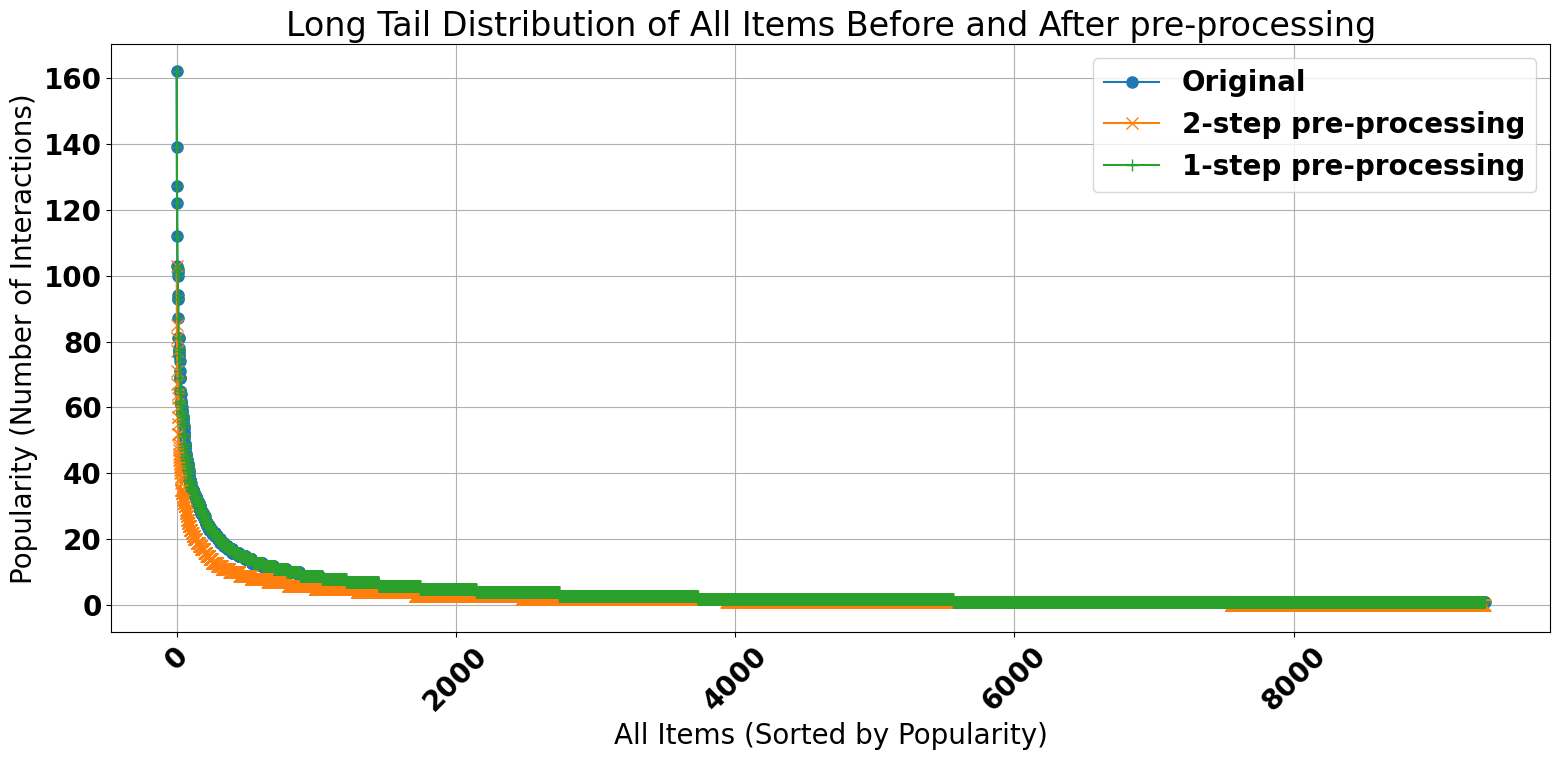

In [618]:
rcParams['font.size'] = 20
rcParams['font.weight'] = 'bold'
# Sample user-item matrix (replace with your data)
user_item_matrix_before = user_item_matrix  # Original data
user_item_matrix_after = obfuscated_user_item_matrix  # Obfuscated data
user_item_matrix_addition = Adding_user_item_matrix  # Obfuscated data

# Calculate item popularity (number of ratings each item received) for both matrices
item_popularity_before = np.sum(user_item_matrix_before, axis=0)
item_popularity_after = np.sum(user_item_matrix_after, axis=0)
item_popularity_addition = np.sum(user_item_matrix_addition, axis=0)

# Sort item popularity values in descending order
sorted_item_popularity_before = np.sort(item_popularity_before)[::-1]
sorted_item_popularity_after = np.sort(item_popularity_after)[::-1]
sorted_item_popularity_addition = np.sort(item_popularity_addition)[::-1]

# Create an array of item IDs based on their popularity (descending order)
item_ids = np.arange(1, len(item_popularity_before) + 1)

# Create a long-tail distribution plot for all items
plt.figure(figsize=(16, 8))  # Adjust the size as needed
plt.plot(item_ids, sorted_item_popularity_before, label='Original', marker='o', markersize=8, linestyle='-')
plt.plot(item_ids, sorted_item_popularity_after, label='2-step pre-processing', marker='x', markersize=8, linestyle='-')
plt.plot(item_ids, sorted_item_popularity_addition, label='1-step pre-processing', marker='+', markersize=8, linestyle='-')
plt.xlabel('All Items (Sorted by Popularity)')
plt.ylabel('Popularity (Number of Interactions)')
plt.xticks(rotation=45)
plt.title('Long Tail Distribution of All Items Before and After pre-processing')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
output_filename = f"Long_Tail_Distribution_Items_p_{p_obfuscation}_users_{nb_users}_{nb_items}_items.pdf"
output_path_fig = "MIND/mind_version1/MIND_demo/Figures/Random/"  
output_full_path = os.path.join(output_path_fig, output_filename)
plt.savefig(output_full_path)
plt.show()


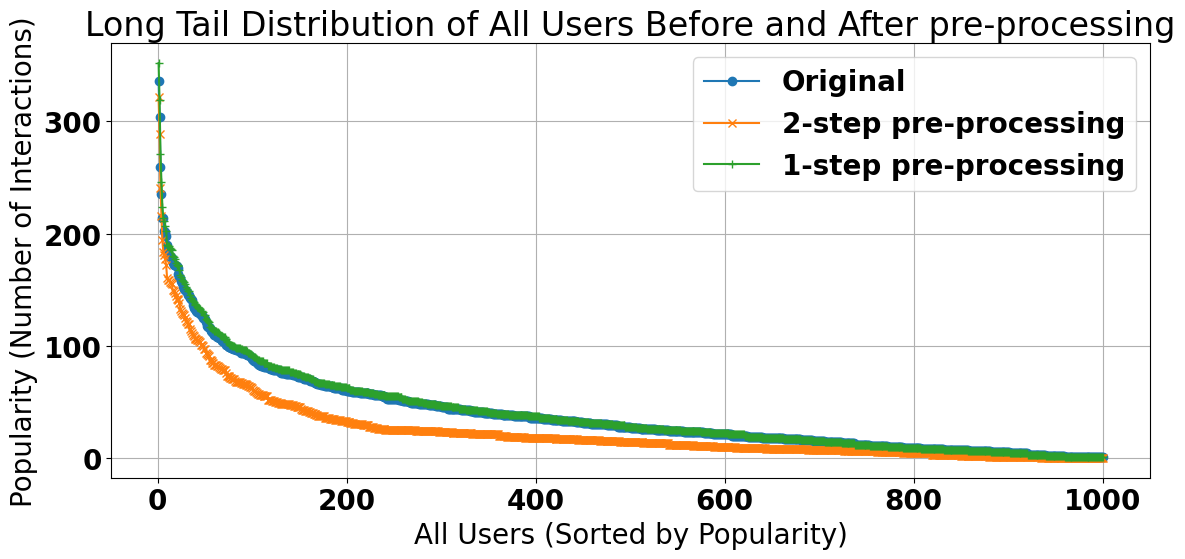

In [619]:

# Sample user-item matrix (replace with your data)
user_item_matrix_before = user_item_matrix  # Original data
user_item_matrix_after = obfuscated_user_item_matrix  # Obfuscated data
user_item_matrix_after1 = Adding_user_item_matrix  # Obfuscated data

# Calculate item popularity (number of ratings each item received) for both matrices
user_popularity_before = np.sum(user_item_matrix_before, axis=1)
user_popularity_after = np.sum(user_item_matrix_after, axis=1)
user_popularity_after1 = np.sum(user_item_matrix_after1, axis=1)

# Sort item popularity values in descending order
sorted_user_popularity_before = np.sort(user_popularity_before)[::-1]
sorted_user_popularity_after = np.sort(user_popularity_after)[::-1]
sorted_user_popularity_after1 = np.sort(user_popularity_after1)[::-1]

# Create an array of item IDs based on their popularity (descending order)
user_ids = np.arange(1, len(user_popularity_before) + 1)

# Create a long-tail distribution plot for all items
plt.figure(figsize=(12, 6))
plt.plot(user_ids, sorted_user_popularity_before, label='Original', marker='o', linestyle='-')
plt.plot(user_ids, sorted_user_popularity_after, label='2-step pre-processing', marker='x', linestyle='-')
plt.plot(user_ids, sorted_user_popularity_after1, label='1-step pre-processing', marker='+', linestyle='-')
plt.xlabel('All Users (Sorted by Popularity)')
plt.ylabel('Popularity (Number of Interactions)')
plt.title('Long Tail Distribution of All Users Before and After pre-processing')
plt.legend()
plt.grid(True)
plt.tight_layout()
output_filename = f"Long_Tail_Distribution_Users_p_{p_obfuscation}_users_{nb_users}_{nb_items}_items.pdf"
output_path_fig = "MIND/mind_version1/MIND_demo/Figures/Random/"  # 
output_full_path = os.path.join(output_path_fig, output_filename)
plt.savefig(output_full_path)
plt.show()

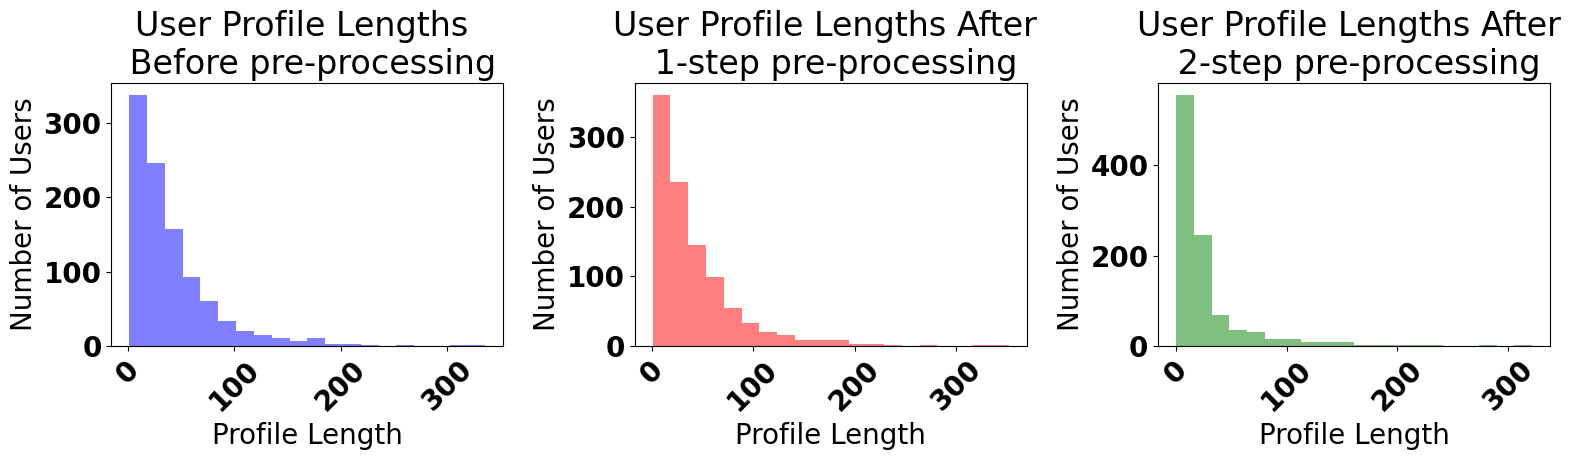

In [621]:
# User Profile Length (Histogram)
user_profile_lengths_before = np.sum(user_item_matrix_before > 0, axis=1)
user_profile_lengths_after = np.sum(user_item_matrix_after > 0, axis=1)
user_profile_lengths_after1 = np.sum(user_item_matrix_after1 > 0, axis=1)

plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.hist(user_profile_lengths_before, bins=20, alpha=0.5, color='b')
plt.xlabel('Profile Length')
plt.xticks(rotation=45)
plt.ylabel('Number of Users')
plt.title('User Profile Lengths \n Before pre-processing')
# plt.yticks(np.arange(0, max(user_profile_lengths_before)+1, 1).astype(int))

plt.subplot(132)
plt.hist(user_profile_lengths_after1, bins=20, alpha=0.5, color='r')
plt.xlabel('Profile Length')
plt.xticks(rotation=45)
plt.ylabel('Number of Users')
plt.title('User Profile Lengths After \n 1-step pre-processing')
# plt.yticks(np.arange(0, max(user_profile_lengths_after1)+1, 1).astype(int)

plt.subplot(133)
plt.hist(user_profile_lengths_after, bins=20, alpha=0.5, color='g')
plt.xlabel('Profile Length')
plt.xticks(rotation=45)
plt.ylabel('Number of Users')
plt.title('User Profile Lengths After \n 2-step pre-processing')
# plt.yticks(np.arange(0, max(user_profile_lengths_after)+1, 1).astype(int)
plt.tight_layout()
output_filename = f"User_Profile_Lengths_{p_obfuscation}_users_{nb_users}_{nb_items}_items.pdf"
output_path_fig = "MIND/mind_version1/MIND_demo/Figures/Random/"  # Replace with the desired path
output_full_path = os.path.join(output_path_fig, output_filename)
plt.savefig(output_full_path)
plt.show()


a t-SNE plot is a valuable tool for visualizing high-dimensional data, identifying clusters, and exploring patterns. Understanding the data and the context in which it was generated is crucial for interpreting the results effectively

the plot shows how user clusters change before and after obfuscation using a t-SNE plot. 

In [624]:
# Sample or generate new item_ids based on the unique_item_ids
num_samples = 9368 # 15558  # Adjust the number of samples as needed
sampled_item_ids = np.random.choice(train_MIND_categories.click_history.unique(), size=num_samples, replace=True)

# Create a new DataFrame with the sampled_item_ids
new_item_df = pd.DataFrame({'item_id': sampled_item_ids})

# print (new_item_df)
# Iterate through the rows in the data frame
for index, row in enumerate(item_features):
    categories = row.split(':')
    for category in categories:
        # print (category)
        if category not in new_item_df.columns:
            new_item_df[category] = 0
        new_item_df.loc[index, category] = 1

# print (new_item_df)
# Initialize an empty dictionary to store indicative users for each category
users_by_category = {}

# Iterate through each unique category label
# unique_categories = np.unique(item_features)
# unique_categories = np.unique(new_item_df.columns)
unique_categories = new_item_df.loc[:, new_item_df.columns != "item_id"]
unique_categories = unique_categories.columns
# print (unique_categories)
for category in unique_categories:
    # Initialize a logistic regression model for binary classification
    logistic_model = LogisticRegression()
    
    # Create a binary label vector for the current category
    category_labels = new_item_df[category]
    
    # Fit the logistic regression model for the current category
    logistic_model.fit(item_user_matrix, category_labels)
    
    # Get the coefficients for each user
    user_coefficients = logistic_model.coef_[0]
    
    # Find users with positive coefficients (indicative of the current category)
    category_users = np.where(user_coefficients > 0)[0]#[:100]
    
    # # Map the new user IDs back to their original IDs
    # original_user_ids = [reverse_user_id_mapping[new_user_id] for new_user_id in category_users]
    
    # # Store the users in the dictionary under each category
    # users_by_category[category] = original_user_ids
    users_by_category[category] = list(category_users)



In [625]:
# Sample or generate new item_ids based on the unique_item_ids
num_samples = 9368# 15558  # Adjust the number of samples as needed
sampled_item_ids = np.random.choice(train_MIND_categories.click_history.unique(), size=num_samples, replace=True)

# Create a new DataFrame with the sampled_item_ids
new_item_df = pd.DataFrame({'item_id': sampled_item_ids})

# print (new_item_df)
# Iterate through the rows in the data frame
for index, row in enumerate(item_features):
    categories = row.split(':')
    for category in categories:
        # print (category)
        if category not in new_item_df.columns:
            new_item_df[category] = 0
        new_item_df.loc[index, category] = 1

# print (new_item_df)
# Initialize an empty dictionary to store indicative users for each category
users_by_category_After = {}

# Iterate through each unique category label
# unique_categories = np.unique(item_features)
# unique_categories = np.unique(new_item_df.columns)
unique_categories = new_item_df.loc[:, new_item_df.columns != "item_id"]
unique_categories = unique_categories.columns
# print (unique_categories)
for category in unique_categories:
    # Initialize a logistic regression model for binary classification
    logistic_model = LogisticRegression()
    
    # Create a binary label vector for the current category
    category_labels = new_item_df[category]
    
    # Fit the logistic regression model for the current category
    logistic_model.fit(user_item_matrix_after.T, category_labels)
    
    # Get the coefficients for each user
    user_coefficients = logistic_model.coef_[0]
    
    # Find users with positive coefficients (indicative of the current category)
    category_users = np.where(user_coefficients > 0)[0]#[:100]
    
    # # Map the new user IDs back to their original IDs
    # original_user_ids = [reverse_user_id_mapping[new_user_id] for new_user_id in category_users]
    
    # # Store the users in the dictionary under each category
    # users_by_category_After[category] = original_user_ids
    users_by_category_After[category] = list(category_users)



In [626]:
# Sample or generate new item_ids based on the unique_item_ids
num_samples = 9368 # 15558  # Adjust the number of samples as needed
sampled_item_ids = np.random.choice(train_MIND_categories.click_history.unique(), size=num_samples, replace=True)

# Create a new DataFrame with the sampled_item_ids
new_item_df = pd.DataFrame({'item_id': sampled_item_ids})

# print (new_item_df)
# Iterate through the rows in the data frame
for index, row in enumerate(item_features):
    categories = row.split(':')
    for category in categories:
        # print (category)
        if category not in new_item_df.columns:
            new_item_df[category] = 0
        new_item_df.loc[index, category] = 1

# print (new_item_df)
# Initialize an empty dictionary to store indicative users for each category
users_by_category_Addition = {}

# Iterate through each unique category label
# unique_categories = np.unique(item_features)
# unique_categories = np.unique(new_item_df.columns)
unique_categories = new_item_df.loc[:, new_item_df.columns != "item_id"]
unique_categories = unique_categories.columns
# print (unique_categories)
for category in unique_categories:
    # Initialize a logistic regression model for binary classification
    logistic_model = LogisticRegression()
    
    # Create a binary label vector for the current category
    category_labels = new_item_df[category]
    
    # Fit the logistic regression model for the current category
    logistic_model.fit(Adding_user_item_matrix.T, category_labels)
    
    # Get the coefficients for each user
    user_coefficients = logistic_model.coef_[0]
    
    # Find users with positive coefficients (indicative of the current category)
    category_users = np.where(user_coefficients > 0)[0]#[:100]
    

    users_by_category_Addition[category] = list(category_users)



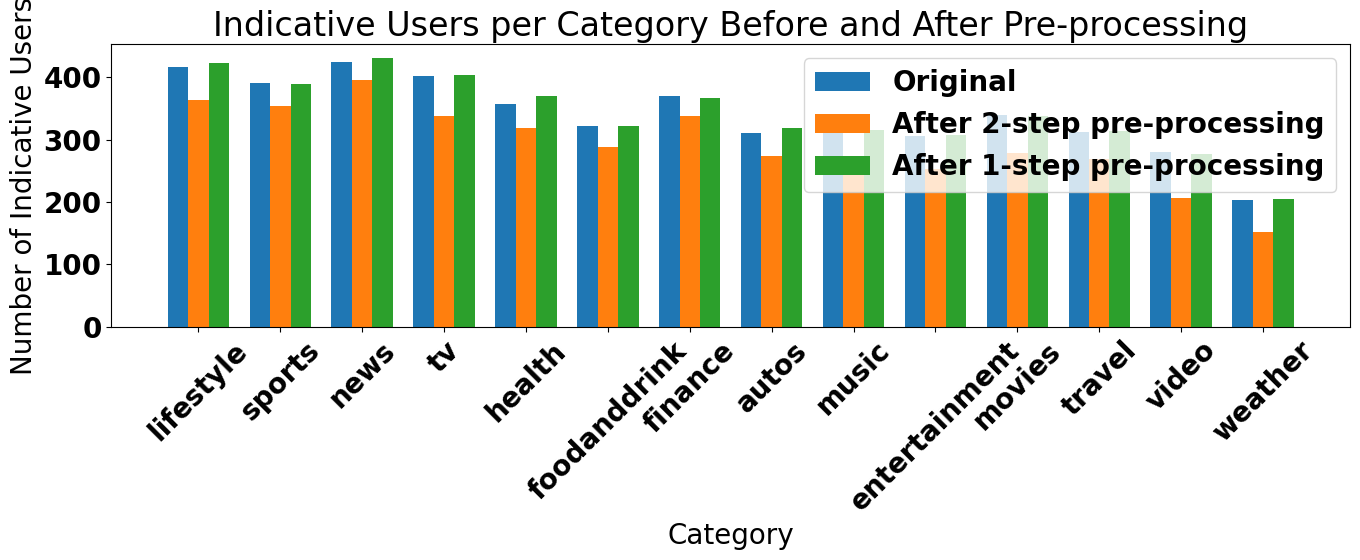

In [627]:
# Define indicative users for each category before and after obfuscation
indicative_users_before = users_by_category
indicative_users_after = users_by_category_After
indicative_users_addition = users_by_category_Addition

# Extract category names and indicative user lists
category_names = indicative_users_before.keys()
users_before = [len(users) for users in indicative_users_before.values()]
users_after = [len(users) for users in indicative_users_after.values()]
users_addition = [len(users) for users in indicative_users_addition.values()]

# Create bar chart to compare users before and after obfuscation
fig, ax = plt.subplots(figsize=(14, 6))
bar_width = 0.25
index = range(len(category_names))

bar1 = ax.bar(index, users_before, bar_width, label='Original')
bar2 = ax.bar([i + bar_width for i in index], users_after, bar_width, label='After 2-step pre-processing')
bar3 = ax.bar([i + 2 * bar_width for i in index], users_addition, bar_width, label='After 1-step pre-processing')

ax.set_xlabel('Category')
ax.set_ylabel('Number of Indicative Users')
ax.set_title('Indicative Users per Category Before and After Pre-processing')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(category_names, rotation=45)
ax.legend()

plt.tight_layout()
# Save the plot to a PDF file with parameters in the filename
output_filename = f"Indicative_UsersperCategory_{p_obfuscation}_users_{nb_users}_{nb_items}_items.pdf"
output_path_fig = "MIND/mind_version1/MIND_demo/Figures/Random/"  # Replace with the desired path
output_full_path = os.path.join(output_path_fig, output_filename)
plt.savefig(output_full_path)
plt.show()


In [628]:
train_MIND_categories

,userId,click_history,category,userIdx,itemIdx
0,U82271,N3130,lifestyle,1,1
1,U82271,N11621,sports,1,2
2,U82271,N12917,news,1,3
3,U82271,N4574,tv,1,4
4,U82271,N12140,sports,1,5
...,...,...,...,...,...
39379,U47006,N24461,health,1000,12
39380,U47006,N14065,lifestyle,1000,133
39381,U47006,N425,lifestyle,1000,60
39382,U47006,N5697,sports,1000,3433


What if we want to use another algorithm to find indicative users?

# Create the final Click_history

Now that we have the pre-processed click_history, we will put the column as in it is original format in behavior.tsv. Then we will create a new_behavior.tsv with the adjusted click history.

In [630]:
# train_MIND_categories.userId.value_counts ()
user_counts_orig = train_MIND_categories['userId'].value_counts()#.head(15)
user_counts_orig

U79449    336
U54826    304
U44210    259
U72280    235
U14271    214
         ... 
U38248      1
U40535      1
U88124      1
U59111      1
U13959      1
Name: userId, Length: 1000, dtype: int64

In [631]:
# df.user_id.value_counts ()
user_counts = df['userId'].value_counts()#.head(15)
user_counts

U79449    352
U54826    319
U44210    271
U72280    246
U13314    224
         ... 
U38248      1
U40535      1
U88124      1
U59111      1
U13959      1
Name: userId, Length: 1000, dtype: int64

In [632]:
# df_obfuscated.user_id.value_counts ()
user_counts_obf = df_obfuscated['userId'].value_counts()#.head(15)
user_counts_obf

U79449    322
U54826    289
U44210    241
U72280    216
U13314    194
         ... 
U45291      1
U17157      1
U26090      1
U56921      1
U46332      1
Name: userId, Length: 934, dtype: int64

In [633]:
# Assuming user_counts_orig, user_counts, and user_counts_obf are already defined
# Convert value_counts to DataFrames for easy comparison
user_counts_orig_df = user_counts_orig.reset_index().rename(columns={'index': 'userId', 'userId': 'count_orig'})
user_counts_df = user_counts.reset_index().rename(columns={'index': 'userId', 'userId': 'count'})
user_counts_obf_df = user_counts_obf.reset_index().rename(columns={'index': 'userId', 'userId': 'count_obf'})

# Merge the DataFrames on 'userId'
merged_counts = pd.merge(user_counts_orig_df, user_counts_df, on='userId', how='outer', suffixes=('_orig', '_df'))
merged_counts = pd.merge(merged_counts, user_counts_obf_df, on='userId', how='outer')

# Find users with different value counts
different_counts_users = merged_counts[
    (merged_counts['count_orig'].notnull() & (merged_counts['count_orig'] != merged_counts['count'])) |
    (merged_counts['count'].notnull() & (merged_counts['count'] != merged_counts['count_obf'])) |
    (merged_counts['count_orig'].notnull() & (merged_counts['count_orig'] != merged_counts['count_obf']))
]

different_counts_users


,userId,count_orig,count,count_obf
0,U79449,336,352,322.0
1,U54826,304,319,289.0
2,U44210,259,271,241.0
3,U72280,235,246,216.0
4,U14271,214,214,184.0
...,...,...,...,...
620,U75909,20,21,21.0
621,U13638,20,21,21.0
622,U74606,20,21,21.0
623,U10474,20,21,21.0


In [634]:
# Assuming user_counts_orig, user_counts, and user_counts_obf are already defined
# Convert value_counts to DataFrames for easy comparison
user_counts_orig_df = user_counts_orig.reset_index().rename(columns={'index': 'userId', 'userId': 'count_orig'})
user_counts_df = user_counts.reset_index().rename(columns={'index': 'userId', 'userId': 'count'})
user_counts_obf_df = user_counts_obf.reset_index().rename(columns={'index': 'userId', 'userId': 'count_obf'})

# Merge the DataFrames on 'userId'
merged_counts = pd.merge(user_counts_orig_df, user_counts_df, on='userId', how='outer', suffixes=('_orig', '_df'))
merged_counts = pd.merge(merged_counts, user_counts_obf_df, on='userId', how='outer')

# Find users with the same value counts
same_counts_users = merged_counts[
    (merged_counts['count_orig'].notnull() & (merged_counts['count_orig'] == merged_counts['count'])) &
    (merged_counts['count'].notnull() & (merged_counts['count'] == merged_counts['count_obf'])) &
    (merged_counts['count_orig'].notnull() & (merged_counts['count_orig'] == merged_counts['count_obf']))
]

print(same_counts_users)


     userId  count_orig  count  count_obf
527  U57919          25     25       25.0
531  U21679          25     25       25.0
533  U31934          25     25       25.0
535  U46665          25     25       25.0
539  U19468          25     25       25.0
..      ...         ...    ...        ...
995  U38248           1      1        1.0
996  U40535           1      1        1.0
997  U88124           1      1        1.0
998  U59111           1      1        1.0
999  U13959           1      1        1.0

[397 rows x 4 columns]


In [635]:
result_df_original = train_MIND_categories.groupby('userId')['click_history'].agg(lambda x: ' '.join(map(str, x))).reset_index()
result_df_Addition = df.groupby('userId')['click_history'].agg(lambda x: ' '.join(map(str, x))).reset_index()
result_df_obfuscated = df_obfuscated.groupby('userId')['click_history'].agg(lambda x: ' '.join(map(str, x))).reset_index()

In [636]:
result_df_original['item_length'] = result_df_original['click_history'].apply(lambda x: len(x.split()))
result_df_Addition['item_length'] = result_df_Addition['click_history'].apply(lambda x: len(x.split()))
result_df_obfuscated['item_length'] = result_df_obfuscated['click_history'].apply(lambda x: len(x.split()))
# result_df_Addition

In [637]:
# result_df_original

In [638]:
result_df_obfuscated

,userId,click_history,item_length
0,U10044,N3994 N4384 N14065 N3790 N18426 N17008 N12818 ...,21
1,U10062,N11723 N25457 N27591 N828 N10231 N24245 N22194...,111
2,U10103,N27209 N25457 N13820 N27591 N28322 N828 N17674...,131
3,U1019,N11723 N12838 N20209 N17446 N19841 N14435,6
4,U10233,N10231 N8238 N6887 N12079 N20416 N11061 N2365 ...,47
...,...,...,...
929,U9567,N11950 N26676 N18426 N15336 N7281,5
930,U9603,N425 N7390 N22599 N2001 N12162 N5229,6
931,U9658,N11723 N11751 N12242 N3842 N17579 N24917 N2250...,49
932,U9935,nan,1


In [639]:
user_ids_df1 = set(result_df_original['userId'])
user_ids_df2 = set(result_df_Addition['userId'])
user_ids_df3 = set(result_df_obfuscated['userId'])

# Find user_ids that are unique to each dataframe
unique_user_ids_df1 = user_ids_df1 - user_ids_df2 - user_ids_df3
unique_user_ids_df2 = user_ids_df2 - user_ids_df1 - user_ids_df3
unique_user_ids_df3 = user_ids_df3 - user_ids_df1 - user_ids_df2

# Combine unique user_ids from all dataframes
all_unique_user_ids = unique_user_ids_df1.union(unique_user_ids_df2, unique_user_ids_df3)

print("User_ids unique to df1:", unique_user_ids_df1)
print("User_ids unique to df2:", unique_user_ids_df2)
print("User_ids unique to df3:", unique_user_ids_df3)
print("All unique user_ids across all dataframes:", all_unique_user_ids)

User_ids unique to df1: set()
User_ids unique to df2: set()
User_ids unique to df3: set()
All unique user_ids across all dataframes: set()


In [640]:
user_ids_df1 = set(result_df_original['userId'])
user_ids_df2 = set(result_df_Addition['userId'])
user_ids_df3 = set(result_df_obfuscated['userId'])

# Find user_ids common to all dataframes
common_user_ids = user_ids_df1.intersection(user_ids_df2, user_ids_df3)

print("User_ids common to all dataframes:", len(common_user_ids))

User_ids common to all dataframes: 934


In [641]:
## Save
output_path = "MIND/mind_version1/MIND_Demo_Version1/train/preprocess/Random/"


In [642]:
# MINDsmall_train
raw_behaviour = pd.read_csv(
    "MIND/mind_version1/MIND_Demo_Version1/train/behaviors.tsv", 
    sep="\t",
    names=["impressionId","userId","timestamp","click_history","impressions"])

print(f"The dataset consist of {len(raw_behaviour)} number of interactions.")
raw_behaviour.head()

The dataset consist of 22034 number of interactions.


,impressionId,userId,timestamp,click_history,impressions
0,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...
1,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...
2,3,U11552,11/11/2019 1:03:52 PM,N2139,N18390-0 N10537-0 N23967-1
3,4,U68381,11/11/2019 6:44:05 AM,N27420 N11621 N25416 N25457 N5124 N11751 N1175...,N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...
4,5,U52303,11/12/2019 3:11:52 AM,N1332 N12667,N15645-0 N7911-1


In [643]:
# Use isin to filter raw_behaviour based on selected_user_ids
selected_behaviour = raw_behaviour[raw_behaviour['userId'].isin(train_MIND_categories['userId'])]
# selected_behaviour.head (40)
# duplicatet = selected_behaviour[selected_behaviour.duplicated(subset=['userId', 'click_history'], keep=False)]
selected_behaviour#.head()

,impressionId,userId,timestamp,click_history,impressions
0,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...
1,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...
2,3,U11552,11/11/2019 1:03:52 PM,N2139,N18390-0 N10537-0 N23967-1
3,4,U68381,11/11/2019 6:44:05 AM,N27420 N11621 N25416 N25457 N5124 N11751 N1175...,N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...
4,5,U52303,11/12/2019 3:11:52 AM,N1332 N12667,N15645-0 N7911-1
...,...,...,...,...,...
22012,22013,U93315,11/13/2019 12:03:56 PM,N2178 N19164 N624 N4827 N20692 N12202 N26569 N...,N22346-0 N23627-0 N27650-0 N18057-1 N4043-0
22018,22019,U26646,11/13/2019 12:37:52 PM,N27627 N6809 N26676 N19435 N425 N109 N21122 N2...,N23604-0 N28036-0 N11489-0 N24231-0 N20702-0 N...
22027,22028,U28121,11/13/2019 7:54:13 AM,N3076 N12157 N18347 N7851 N10593 N4130 N8744 N...,N1968-0 N3065-0 N5309-1 N21807-0 N14777-0 N268...
22028,22029,U92961,11/13/2019 7:23:30 AM,N7216 N18359 N22427 N18766 N13565 N4973 N16386...,N23470-0 N4460-0 N10074-0 N8545-0 N16385-0 N21...


In [644]:
selected_behaviour_copy = selected_behaviour [['impressionId', 'userId', 'timestamp', 'impressions']]
# result_df_obfuscated = result_df_obfuscated.rename(columns={'user_id': 'userId'})
merged_df_obfuscated = pd.merge(result_df_obfuscated, selected_behaviour_copy, on='userId')#, how='left')
# merged_df_obfuscated = merged_df_obfuscated.drop('click_history', axis=1)

# # Rename another variable (e.g., 'item_id' to 'click_history')
# merged_df_obfuscated = merged_df_obfuscated.rename(columns={'item_id': 'click_history'})

# Define the desired order of columns
column_order = ['impressionId', 'userId', 'timestamp', 'click_history', 'impressions']  

# # Reorder the DataFrame columns
merged_df_obfuscated = merged_df_obfuscated[column_order]

# # merged_df_obfuscated.to_csv(output_path + "merged_df_obfuscated_1%_new.tsv", sep='\t', index=False, header=False)
merged_df_obfuscated.sort_values(by= 'impressionId', inplace= True)
merged_df_obfuscated#.head ()

,impressionId,userId,timestamp,click_history,impressions
5664,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...
5798,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...
145,3,U11552,11/11/2019 1:03:52 PM,N2139,N18390-0 N10537-0 N23967-1
4477,4,U68381,11/11/2019 6:44:05 AM,N11621 N27420 N5124 N11751 N16918 N27030 N2463...,N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...
3273,5,U52303,11/12/2019 3:11:52 AM,N1332 N12667,N15645-0 N7911-1
...,...,...,...,...,...
3224,22012,U51124,11/14/2019 3:36:26 AM,N14065 N8544 N12838 N20825 N17086 N12202 N2645...,N24783-0 N25155-0 N12071-0 N12328-0 N25620-0 N...
6641,22013,U93315,11/13/2019 12:03:56 PM,N14026 N8067 N425 N26676 N17579 N26569 N4726 N...,N22346-0 N23627-0 N27650-0 N18057-1 N4043-0
1273,22019,U26646,11/13/2019 12:37:52 PM,N425 N14201 N26676 N17086 N25695 N27326 N24954...,N23604-0 N28036-0 N11489-0 N24231-0 N20702-0 N...
1358,22028,U28121,11/13/2019 7:54:13 AM,N25232 N24425 N8744,N1968-0 N3065-0 N5309-1 N21807-0 N14777-0 N268...


In [645]:
selected_behaviour_copy = selected_behaviour [['impressionId', 'userId', 'timestamp', 'impressions']]
# result_df_obfuscated = result_df_obfuscated.rename(columns={'user_id': 'userId'})
merged_df_Addition = pd.merge(result_df_Addition, selected_behaviour_copy, on='userId')#, how='left')

column_order = ['impressionId', 'userId', 'timestamp', 'click_history', 'impressions']  

# # Reorder the DataFrame columns
merged_df_Addition = merged_df_Addition[column_order]

# # Save the modified DataFrame
# # merged_df_obfuscated.to_csv(output_path + "merged_df_obfuscated_1%_new.tsv", sep='\t', index=False, header=False)
merged_df_Addition.sort_values(by= 'impressionId', inplace= True)
merged_df_Addition#.head ()

,impressionId,userId,timestamp,click_history,impressions
5983,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...
6129,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...
153,3,U11552,11/11/2019 1:03:52 PM,N2139,N18390-0 N10537-0 N23967-1
4734,4,U68381,11/11/2019 6:44:05 AM,N11621 N27420 N25416 N25457 N5124 N11751 N1691...,N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...
3449,5,U52303,11/12/2019 3:11:52 AM,N1332 N12667,N15645-0 N7911-1
...,...,...,...,...,...
7014,22013,U93315,11/13/2019 12:03:56 PM,N14026 N8067 N425 N4384 N26676 N17579 N15649 N...,N22346-0 N23627-0 N27650-0 N18057-1 N4043-0
1338,22019,U26646,11/13/2019 12:37:52 PM,N425 N14201 N26676 N17086 N25695 N27326 N24954...,N23604-0 N28036-0 N11489-0 N24231-0 N20702-0 N...
1423,22028,U28121,11/13/2019 7:54:13 AM,N12242 N2158 N25232 N14065 N3076 N21816 N1359 ...,N1968-0 N3065-0 N5309-1 N21807-0 N14777-0 N268...
6931,22029,U92961,11/13/2019 7:23:30 AM,N4617 N14776 N20209 N2313 N22427 N17446 N18766...,N23470-0 N4460-0 N10074-0 N8545-0 N16385-0 N21...


In [647]:

output_path = "MIND/mind_version1/MIND_Demo_Version1/train/preprocess/Greedy/"
# selected_behaviour.to_csv (output_path + f"original_{nb_items}Items_{nb_users}Users_behavior.tsv", sep='\t', index=False, header=False)


In [648]:

merged_df_Addition.to_csv(output_path + f"preproc_Add_{p_obfuscation}_{nb_items}Items_{nb_users}Users_behavior.tsv", sep='\t', index=False, header=False)
merged_df_obfuscated.to_csv(output_path + f"preproc_Obf_{p_obfuscation}_{nb_items}Items_{nb_users}Users_behavior.tsv", sep='\t', index=False, header=False)

In [649]:
selected_behaviour

,impressionId,userId,timestamp,click_history,impressions
0,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...
1,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...
2,3,U11552,11/11/2019 1:03:52 PM,N2139,N18390-0 N10537-0 N23967-1
3,4,U68381,11/11/2019 6:44:05 AM,N27420 N11621 N25416 N25457 N5124 N11751 N1175...,N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...
4,5,U52303,11/12/2019 3:11:52 AM,N1332 N12667,N15645-0 N7911-1
...,...,...,...,...,...
22012,22013,U93315,11/13/2019 12:03:56 PM,N2178 N19164 N624 N4827 N20692 N12202 N26569 N...,N22346-0 N23627-0 N27650-0 N18057-1 N4043-0
22018,22019,U26646,11/13/2019 12:37:52 PM,N27627 N6809 N26676 N19435 N425 N109 N21122 N2...,N23604-0 N28036-0 N11489-0 N24231-0 N20702-0 N...
22027,22028,U28121,11/13/2019 7:54:13 AM,N3076 N12157 N18347 N7851 N10593 N4130 N8744 N...,N1968-0 N3065-0 N5309-1 N21807-0 N14777-0 N268...
22028,22029,U92961,11/13/2019 7:23:30 AM,N7216 N18359 N22427 N18766 N13565 N4973 N16386...,N23470-0 N4460-0 N10074-0 N8545-0 N16385-0 N21...


In [650]:
merged_df_obfuscated

,impressionId,userId,timestamp,click_history,impressions
5664,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...
5798,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...
145,3,U11552,11/11/2019 1:03:52 PM,N2139,N18390-0 N10537-0 N23967-1
4477,4,U68381,11/11/2019 6:44:05 AM,N11621 N27420 N5124 N11751 N16918 N27030 N2463...,N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...
3273,5,U52303,11/12/2019 3:11:52 AM,N1332 N12667,N15645-0 N7911-1
...,...,...,...,...,...
3224,22012,U51124,11/14/2019 3:36:26 AM,N14065 N8544 N12838 N20825 N17086 N12202 N2645...,N24783-0 N25155-0 N12071-0 N12328-0 N25620-0 N...
6641,22013,U93315,11/13/2019 12:03:56 PM,N14026 N8067 N425 N26676 N17579 N26569 N4726 N...,N22346-0 N23627-0 N27650-0 N18057-1 N4043-0
1273,22019,U26646,11/13/2019 12:37:52 PM,N425 N14201 N26676 N17086 N25695 N27326 N24954...,N23604-0 N28036-0 N11489-0 N24231-0 N20702-0 N...
1358,22028,U28121,11/13/2019 7:54:13 AM,N25232 N24425 N8744,N1968-0 N3065-0 N5309-1 N21807-0 N14777-0 N268...


In [651]:
merged_df_Addition

,impressionId,userId,timestamp,click_history,impressions
5983,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...
6129,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...
153,3,U11552,11/11/2019 1:03:52 PM,N2139,N18390-0 N10537-0 N23967-1
4734,4,U68381,11/11/2019 6:44:05 AM,N11621 N27420 N25416 N25457 N5124 N11751 N1691...,N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...
3449,5,U52303,11/12/2019 3:11:52 AM,N1332 N12667,N15645-0 N7911-1
...,...,...,...,...,...
7014,22013,U93315,11/13/2019 12:03:56 PM,N14026 N8067 N425 N4384 N26676 N17579 N15649 N...,N22346-0 N23627-0 N27650-0 N18057-1 N4043-0
1338,22019,U26646,11/13/2019 12:37:52 PM,N425 N14201 N26676 N17086 N25695 N27326 N24954...,N23604-0 N28036-0 N11489-0 N24231-0 N20702-0 N...
1423,22028,U28121,11/13/2019 7:54:13 AM,N12242 N2158 N25232 N14065 N3076 N21816 N1359 ...,N1968-0 N3065-0 N5309-1 N21807-0 N14777-0 N268...
6931,22029,U92961,11/13/2019 7:23:30 AM,N4617 N14776 N20209 N2313 N22427 N17446 N18766...,N23470-0 N4460-0 N10074-0 N8545-0 N16385-0 N21...


In [652]:
merged_df_obfuscated['is_duplicate'] = merged_df_obfuscated.duplicated(subset=['userId', 'click_history'], keep=False)

In [653]:
# Check if all columns except 'click_history' are equal
other_columns_equal = (selected_behaviour.drop('click_history', axis=1).equals(merged_df_Addition.drop('click_history', axis=1)) and 
                       merged_df_Addition.drop('click_history', axis=1).equals(merged_df_obfuscated.drop('click_history', axis=1)))

# Check if 'click_history' is different in at least one dataset
click_history_different = not (selected_behaviour['click_history'].equals(merged_df_Addition['click_history']) and merged_df_Addition['click_history'].equals(merged_df_obfuscated['click_history']))

if other_columns_equal and click_history_different:
    print("The only differing column is 'click_history'.")
else:
    print("There are differences in columns other than 'click_history'.")
df1 = selected_behaviour.copy()
df2 = merged_df_Addition.copy()
df3 = merged_df_obfuscated.copy()
# Add a unique identifier to each row in each DataFrame
df1['unique_id'] = df1.groupby('userId').cumcount()
df2['unique_id'] = df2.groupby('userId').cumcount()
df3['unique_id'] = df3.groupby('userId').cumcount()

# Align DataFrames based on 'userId' and 'unique_id'
merged_df_list = [df1, df2, df3]
merged_df_list_aligned = [df.set_index(['userId', 'unique_id']) for df in merged_df_list]
aligned_df = pd.concat(merged_df_list_aligned, axis=1, keys=['df1', 'df2', 'df3'])

# Find the rows where 'click_history' differs in at least one dataset
diff_rows = aligned_df[('df1', 'click_history')] != aligned_df[('df2', 'click_history')]
diff_rows |= aligned_df[('df2', 'click_history')] != aligned_df[('df3', 'click_history')]

# Filter rows with differences
result_diff = aligned_df[diff_rows].reset_index()
result_diff


There are differences in columns other than 'click_history'.


userId unique_id          df1                          \
                       impressionId               timestamp   
0     U68381         0            4   11/11/2019 6:44:05 AM   
1     U26536         0            6   11/11/2019 3:13:36 PM   
2     U70695         0           10   11/12/2019 1:52:07 AM   
3     U72944         0           12   11/12/2019 7:27:24 AM   
4     U90734         0           14    11/9/2019 9:27:22 AM   
...      ...       ...          ...                     ...   
6980  U93315        15        22013  11/13/2019 12:03:56 PM   
6981  U26646         3        22019  11/13/2019 12:37:52 PM   
6982  U28121         9        22028   11/13/2019 7:54:13 AM   
6983  U92961         9        22029   11/13/2019 7:23:30 AM   
6984   U6774         2        22034    11/9/2019 7:18:24 AM   

                                                         \
                                          click_history   
0     N27420 N11621 N25416 N25457 N5124 N11751 N1175...   
1     N17674 N7165 N18669 N20855 N9748 N44 N24245 N2...   
2     N1724 N19635 N8238 N22753 N17607 N14340 N6383 ...   
3     N3076 N6887 N16955 N16699 N27700 N23620 N9045 ...   
4     N13543 N3823 N12627 N15621 N15366 N26569 N3299...   
...                                                 ...   
6980  N2178 N19164 N624 N4827 N20692 N12202 N26569 N...   
6981  N27627 N6809 N26676 N19435 N425 N109 N21122 N2...   
6982  N3076 N12157 N18347 N7851 N10593 N4130 N8744 N...   
6983  N7216 N18359 N22427 N18766 N13565 N4973 N16386...   
6984  N3076 N4202 N16681 N12933 N283 N26459 N25436 N...   

                                                                 df2  \
                                            impressions impressionId   
0     N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...            4   
1     N15244-0 N2167-0 N20122-0 N16945-0 N9480-0 N36...            6   
2     N17632-0 N16474-0 N16008-0 N3244-0 N17968-0 N2...           10   
3     N9310-1 N977-0 N28002-0 N19695-0 N7911-0 N2429...           12   
4     N824-0 N14864-0 N14445-0 N21822-0 N8837-0 N248...           14   
...                                                 ...          ...   
6980        N22346-0 N23627-0 N27650-0 N18057-1 N4043-0        22013   
6981  N23604-0 N28036-0 N11489-0 N24231-0 N20702-0 N...        22019   
6982  N1968-0 N3065-0 N5309-1 N21807-0 N14777-0 N268...        22028   
6983  N23470-0 N4460-0 N10074-0 N8545-0 N16385-0 N21...        22029   
6984  N5109-0 N7452-0 N13064-0 N26428-0 N22785-0 N23...        22034   

                              \
                   timestamp   
0      11/11/2019 6:44:05 AM   
1      11/11/2019 3:13:36 PM   
2      11/12/2019 1:52:07 AM   
3      11/12/2019 7:27:24 AM   
4       11/9/2019 9:27:22 AM   
...                      ...   
6980  11/13/2019 12:03:56 PM   
6981  11/13/2019 12:37:52 PM   
6982   11/13/2019 7:54:13 AM   
6983   11/13/2019 7:23:30 AM   
6984    11/9/2019 7:18:24 AM   

                                                         \
                                          click_history   
0     N11621 N27420 N25416 N25457 N5124 N11751 N1691...   
1     N9748 N17674 N7165 N18669 N20855 N44 N24245 N2...   
2     N4617 N1724 N19635 N8238 N22753 N17607 N14340 ...   
3     N2242 N3076 N6887 N16955 N16699 N27700 N23620 ...   
4     N27079 N14065 N25054 N13543 N3823 N12627 N1562...   
...                                                 ...   
6980  N14026 N8067 N425 N4384 N26676 N17579 N15649 N...   
6981  N425 N14201 N26676 N17086 N25695 N27326 N24954...   
6982  N12242 N2158 N25232 N14065 N3076 N21816 N1359 ...   
6983  N4617 N14776 N20209 N2313 N22427 N17446 N18766...   
6984  N26260 N3076 N13025 N21816 N4202 N7850 N10647 ...   

                                                                 df3  \
                                            impressions impressionId   
0     N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...          4.0   
1     N15244-0 N2167-0 N20122-0 N16945-0 N9480-0 N36...          6.0   
2     N1

In [654]:
user_U82271 = result_diff[result_diff['userId'] == 'U6774']
user_U82271

userId unique_id          df1                          \
                      impressionId               timestamp   
590   U6774         0          614  11/13/2019 12:28:18 PM   
4461  U6774         1        13047   11/11/2019 7:38:41 AM   
6984  U6774         2        22034    11/9/2019 7:18:24 AM   

                                                         \
                                          click_history   
590   N3076 N4202 N16681 N12933 N283 N26459 N25436 N...   
4461  N3076 N4202 N16681 N12933 N283 N26459 N25436 N...   
6984  N3076 N4202 N16681 N12933 N283 N26459 N25436 N...   

                                                                 df2  \
                                            impressions impressionId   
590   N24231-0 N24674-0 N5821-0 N14044-1 N14544-0 N1...          614   
4461  N23583-0 N23043-0 N20523-0 N17414-0 N23906-0 N...        13047   
6984  N5109-0 N7452-0 N13064-0 N26428-0 N22785-0 N23...        22034   

                              \
                   timestamp   
590   11/13/2019 12:28:18 PM   
4461   11/11/2019 7:38:41 AM   
6984    11/9/2019 7:18:24 AM   

                                                         \
                                          click_history   
590   N26260 N3076 N13025 N21816 N4202 N7850 N10647 ...   
4461  N26260 N3076 N13025 N21816 N4202 N7850 N10647 ...   
6984  N26260 N3076 N13025 N21816 N4202 N7850 N10647 ...   

                                                                 df3  \
                                            impressions impressionId   
590   N24231-0 N24674-0 N5821-0 N14044-1 N14544-0 N1...          NaN   
4461  N23583-0 N23043-0 N20523-0 N17414-0 N23906-0 N...          NaN   
6984  N5109-0 N7452-0 N13064-0 N26428-0 N22785-0 N23...          NaN   

                                                       
     timestamp click_history impressions is_duplicate  
590        NaN           NaN         NaN          NaN  
4461       NaN           NaN         NaN          NaN  
6984       NaN           NaN         NaN          NaN

In [655]:
duplicate_click_history = merged_df_Addition[merged_df_Addition.duplicated(subset=['userId', 'click_history'], keep=False)]
duplicate_click_history

,impressionId,userId,timestamp,click_history,impressions
5983,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...
6129,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...
4734,4,U68381,11/11/2019 6:44:05 AM,N11621 N27420 N25416 N25457 N5124 N11751 N1691...,N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...
3449,5,U52303,11/12/2019 3:11:52 AM,N1332 N12667,N15645-0 N7911-1
1319,6,U26536,11/11/2019 3:13:36 PM,N9748 N17674 N7165 N18669 N20855 N44 N24245 N2...,N15244-0 N2167-0 N20122-0 N16945-0 N9480-0 N36...
...,...,...,...,...,...
7014,22013,U93315,11/13/2019 12:03:56 PM,N14026 N8067 N425 N4384 N26676 N17579 N15649 N...,N22346-0 N23627-0 N27650-0 N18057-1 N4043-0
1338,22019,U26646,11/13/2019 12:37:52 PM,N425 N14201 N26676 N17086 N25695 N27326 N24954...,N23604-0 N28036-0 N11489-0 N24231-0 N20702-0 N...
1423,22028,U28121,11/13/2019 7:54:13 AM,N12242 N2158 N25232 N14065 N3076 N21816 N1359 ...,N1968-0 N3065-0 N5309-1 N21807-0 N14777-0 N268...
6931,22029,U92961,11/13/2019 7:23:30 AM,N4617 N14776 N20209 N2313 N22427 N17446 N18766...,N23470-0 N4460-0 N10074-0 N8545-0 N16385-0 N21...


In [656]:
nan_rows = merged_df_Addition[merged_df_Addition['userId'].isna() & merged_df_Addition['click_history'].isna()]
print(nan_rows)

Empty DataFrame
Columns: [impressionId, userId, timestamp, click_history, impressions]
Index: []


In [657]:
unique_click_history = merged_df_Addition.drop_duplicates(subset=['click_history'], keep='first')
unique_click_history

,impressionId,userId,timestamp,click_history,impressions
5983,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...
6129,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...
153,3,U11552,11/11/2019 1:03:52 PM,N2139,N18390-0 N10537-0 N23967-1
4734,4,U68381,11/11/2019 6:44:05 AM,N11621 N27420 N25416 N25457 N5124 N11751 N1691...,N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...
3449,5,U52303,11/12/2019 3:11:52 AM,N1332 N12667,N15645-0 N7911-1
...,...,...,...,...,...
2054,1189,U36585,11/13/2019 2:51:22 AM,N14026 N28322 N20704 N17579 N28296 N5994 N1281...,N23575-0 N18502-0 N26284-0 N7853-0 N8506-0 N10...
4243,1190,U62446,11/12/2019 6:19:46 AM,N4617 N27420 N25457 N23158 N21627 N20909 N1638...,N22071-0 N7357-0 N20342-0 N24649-0 N4187-0 N33...
3913,1191,U57919,11/14/2019 7:26:17 AM,N11621 N1038 N26748 N2432 N26030 N20953 N21281...,N4840-0 N27001-0 N17978-0 N19366-0 N6889-0 N57...
2465,1193,U40908,11/14/2019 1:55:33 PM,N12667 N9045 N14596,N18368-0 N2022-0 N28587-0 N12833-0 N622-0 N170...
